# Predicting Parole Violators

In many criminal justice systems around the world, inmates deemed not to be a threat to society are released from prison under the parole system prior to completing their sentence. They are still considered to be serving their sentence while on parole, and they can be returned to prison if they violate the terms of their parole.

Parole boards are charged with identifying which inmates are good candidates for release on parole. They seek to release inmates who will not commit additional crimes after release. In this problem, we will build and validate a model that predicts if an inmate will violate the terms of his or her parole. Such a model could be useful to a parole board when deciding to approve or deny an application for parole.

For this prediction task, we will use data from the [United States 2004 National Corrections Reporting Program](http://www.icpsr.umich.edu/icpsrweb/NACJD/series/38/studies/26521?archive=NACJD&sortBy=7), a nationwide census of parole releases that occurred during 2004. We limited our focus to parolees who served no more than 6 months in prison and whose maximum sentence for all charges did not exceed 18 months. The dataset contains all such parolees who either successfully completed their term of parole during 2004 or those who violated the terms of their parole during that year. The dataset contains the following variables:

__male__: 1 if the parolee is male, 0 if female

__race__: 1 if the parolee is white, 2 otherwise

__age__: the parolee's age (in years) when he or she was released from prison

__state__: a code for the parolee's state. 2 is Kentucky, 3 is Louisiana, 4 is Virginia, and 1 is any other state. The three states were selected due to having a high representation in the dataset.

__time.served__: the number of months the parolee served in prison (limited by the inclusion criteria to not exceed 6 months).

__max.sentence__: the maximum sentence length for all charges, in months (limited by the inclusion criteria to not exceed 18 months).

__multiple.offenses__: 1 if the parolee was incarcerated for multiple offenses, 0 otherwise.

__crime__: a code for the parolee's main crime leading to incarceration. 2 is larceny, 3 is drug-related crime, 4 is driving-related crime, and 1 is any other crime.

__violator__: 1 if the parolee violated the parole, and 0 if the parolee completed the parole without violation.

### Loading and understanding data 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
parole = pd.read_csv("./Data/parole.csv")

In [3]:
parole.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 9 columns):
male                 675 non-null int64
race                 675 non-null int64
age                  675 non-null float64
state                675 non-null int64
time.served          675 non-null float64
max.sentence         675 non-null int64
multiple.offenses    675 non-null int64
crime                675 non-null int64
violator             675 non-null int64
dtypes: float64(2), int64(7)
memory usage: 47.6 KB


In [4]:
parole.describe()

,male,race,age,state,time.served,max.sentence,multiple.offenses,crime,violator
count,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000
mean,0.807407,1.423704,34.512296,2.887407,4.198074,13.056296,0.536296,2.059259,0.115556
std,0.394628,0.494511,10.351541,1.226224,1.226855,3.056797,0.499051,1.135892,0.319928
min,0.000000,1.000000,18.400000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,1.000000,1.000000,25.350000,2.000000,3.250000,12.000000,0.000000,1.000000,0.000000
50%,1.000000,1.000000,33.700000,3.000000,4.400000,12.000000,1.000000,2.000000,0.000000
75%,1.000000,2.000000,42.550000,4.000000,5.200000,15.000000,1.000000,3.000000,0.000000
max,1.000000,2.000000,67.000000,4.000000,6.000000,18.000000,1.000000,4.000000,1.000000


How many of the parolees in the dataset violated the terms of their parole?

In [5]:
(parole["violator"].value_counts())

0    597
1     78
Name: violator, dtype: int64

### Prepearing the Dataset

Which variables in this dataset are unordered factors with at least three levels? 

`state`, `crime`

In the last subproblem, we identified variables that are unordered factors with at least 3 levels, so we need to convert them to factors for our prediction problem. Keep in mind that we are not changing the values, the values are still numbers.

How does the output of `describe()` change for a factor variable as compared to a numerical variable?

In [6]:
dict_state = {1:"other", 2:"Kentucky", 3:"Louisiana", 4:"Virginia" }
parole.loc[:, "state"] = parole["state"].map(dict_state)

dict_crime = {1:"other", 2:"larceny", 3:"drug", 4:"driving" }
parole.loc[:, "crime"] = parole["crime"].map(dict_crime)

parole = pd.get_dummies(parole, columns =["state", "crime"])

In [7]:
parole.describe(include="all")

,male,race,age,time.served,max.sentence,multiple.offenses,violator,state_Kentucky,state_Louisiana,state_Virginia,state_other,crime_driving,crime_drug,crime_larceny,crime_other
count,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000
mean,0.807407,1.423704,34.512296,4.198074,13.056296,0.536296,0.115556,0.177778,0.121481,0.488889,0.211852,0.149630,0.226667,0.157037,0.466667
std,0.394628,0.494511,10.351541,1.226855,3.056797,0.499051,0.319928,0.382609,0.326928,0.500247,0.408923,0.356973,0.418986,0.364105,0.499258
min,0.000000,1.000000,18.400000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,25.350000,3.250000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,33.700000,4.400000,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.000000,42.550000,5.200000,15.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,2.000000,67.000000,6.000000,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Splitting into a Training and testing Set

In [8]:
parole.columns

Index(['male', 'race', 'age', 'time.served', 'max.sentence',
       'multiple.offenses', 'violator', 'state_Kentucky', 'state_Louisiana',
       'state_Virginia', 'state_other', 'crime_driving', 'crime_drug',
       'crime_larceny', 'crime_other'],
      dtype='object')

In [9]:
features = ['male', 'race', 'age', 'time.served', 'max.sentence',
       'multiple.offenses', 'state_Kentucky', 'state_Louisiana',
       'state_Virginia', 'state_other', 'crime_driving', 'crime_drug',
       'crime_larceny', 'crime_other']

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(parole.loc[:,features], parole.loc[:, 'violator'], 
                                                    test_size=0.3, random_state=144)

Roughly 70\% of parolees have been allocated to the training and 30\% to the testing sets.

In [11]:
print(f"Train: {len(X_train)} obs., Test: {len(X_test)} obs.")
print(len(X_train)/len(parole), len(X_test)/len(parole))

Train: 472 obs., Test: 203 obs.
0.6992592592592592 0.30074074074074075


### Building a Logistic Regression Model

Train a logistic regression model on the training set. Your dependent variable is "violator", and you should use all of the other variables as independent variables.

What variables are significant in this model? Significant variables should have a probability less than 0.05 (the column Pr(>|z|) in the summary output).

In [12]:
from statsmodels.genmod.generalized_linear_model import GLMResults
import statsmodels.api as sm

X_train["const"] = 1
X_test["const"] = 1

model = sm.GLM(y_train, X_train, family=sm.families.Binomial())

res = model.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               violator   No. Observations:                  472
Model:                            GLM   Df Residuals:                      459
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -124.74
Date:                Fri, 30 Aug 2019   Deviance:                       249.48
Time:                        14:50:25   Pearson chi2:                     445.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
male                  0.4059      0.450      0.903      0.367      -0.475       1.287
race                  0.9175      0.390      2.354      0.019       0.154       1.681
age                   0.0098      0.016      0.609      0.543      -0.022       0.042
time.served          -0.1034      0.119     -0.871      0.384      -0.336       0.129
max.sentence          0.0243      0.051      0.472      0.637      -0.076       0.125
multiple.offenses     1.4155      0.390      3.626      0.000       0.650       2.181
state_Kentucky       -0.0630      0.394     -0.160      0.873      -0.835       0.709
state_Louisiana       0.3908      0.373      1.049      0.294      -0.339       1.121
state_Virginia       -3.3651      0.527     -6.388      0.000      -4.398      -2.333
state_other          -0.0569      0.358     -0.159      0.874      -0.759       0.645
crime_driving        -1.0839      0.532     -2.036      0.042      -2.127      -0.040
crime_drug           -0.8579      0.381     -2.251      0.024      -1.605      -0.111
crime_larceny        -0.6098      0.413     -1.478      0.139      -1.418       0.199
crime_other          -0.5427      0.309     -1.755      0.079      -1.149       0.063
const                -3.0943      0.811     -3.817      0.000      -4.683      -1.505
=====================================================================================
"""

Significant variables are `race`, `state_Virginia`, `multiple.offenses`.

What is the value of Akaike Information Criterion (AIC)?

In [13]:
res.aic

275.48364497328623

What can we say based on the coefficient of the multiple.offenses variable?

Our model predicts that a parolee who committed multiple offense has $e^{1.4155}$=4.12 times higher odds of being a violator than a parolee who did not commit multiple offenses but is otherwise identical.

Logistic function:

\begin{equation}
p(X)=\frac{e^{\beta_{0}+\beta_{1}X_{1}+...+\beta_{p}X_{p}}}{1+e^{\beta_{0}+\beta_{1}X_{1}+...+\beta_{p}X_{p}}}
\end{equation}

After a bit manipulation, we find that

\begin{equation}
\frac{p(X)}{1-p(X)}=e^{\beta_{0}+\beta_{1}X_{1}+...+\beta_{p}X_{p}}
\end{equation}

The quantity in the left part is called _odds_.  See [[1]](#Reference) for more details.

Consider a parolee who is male, of white race, aged 50 years at prison release, from the state of Maryland, served 3 months, had a maximum sentence of 12 months, did not commit multiple offenses, and committed a larceny. Answer the following questions based on the model's predictions for this individual. (HINT: You should use the coefficients of your model, the Logistic Response Function, and the Odds equation to solve this problem.)

According to the model, what are the odds this individual is a violator?

In [14]:
person = pd.Series([1, 1, 50, 3, 12, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1  ], index = res.params.index)
person

male                  1
race                  1
age                  50
time.served           3
max.sentence         12
multiple.offenses     0
state_Kentucky        0
state_Louisiana       0
state_Virginia        0
state_other           1
crime_driving         0
crime_drug            0
crime_larceny         1
crime_other           0
const                 1
dtype: int64

In [15]:
np.exp(sum(person*res.params))

0.1402226816511517

According to the model, what is the probability this individual is a violator?

In [16]:
1/(1+np.exp(-sum(person*res.params)))

0.12297833038025154

### Evaluating the model on the testing data set
Obtain the model's predicted probabilities for parolees in the testing set. What is the maximum predicted probability of a violation?

In [17]:
y_pred = res.predict(X_test)
y_pred.max()

0.7182378450775411

#### Confusion Matrix
A binary classifier can make two types of errors: positive cases that were incorrectly identified as negative and negative cases that were incorrectly identified as positive. Performance of such classifier is evaluated using the _confusion matrix_


$$\begin{matrix}
   Actual/Predicted\\
   \begin{matrix}
   & No & Yes\\
   No & a & b\\
   Yes & c & d
   \end{matrix} 
\end{matrix} $$

#### Accuracy

- $a, d$ are the numbers of _correct_ predictions of negative/positive examples
- $b, c$ are the numbers of _incorrect_ predictions of negative/positive examples
- The _accuracy_ is the proportion of the predictions that are correct
$$ \frac{a+d}{a+b+c+d} $$

#### True Positive Rate, False Positive Rate

- True positive rate is a proportion of positive cases that were correctly identify
$$ TP = \frac{d}{d+c}$$
- False positive rate is a proportion of negative cases that were incorrectly identify
$$ FP = \frac{b}{a+b}$$
- True negative rate is a proportion of negative cases that were correctly identify
$$ TN = \frac{a}{a+b}$$
- False negative rate is a proportion of positive cases that were incorrectly identify
$$ FN = \frac{c}{d+c}$$
- $Sensitivity = TP, Specificity = TN = 1-FP$

#### The ROC

- The ROC curve is a graphic for displaying the two types of errors for all possible _thresholds_
$$ Pr(Y="Yes"|X=x)>threshold$$
- _Threshold_ is the cutoff imposed on the predicted probabilities for assigning observation to each class

#### The ROC, AUC

The overall performance of a classifier is given by the area under the ROC curve (AUC). An ideal ROC curve will hug the top left corner, so the larger the AUC the better classifier.


Confusion Matrix:

In [18]:
conf_m = pd.crosstab(y_test, y_pred >= 0.5)
conf_m

col_0,False,True
violator,,
0,175,5
1,18,5


In the following questions, evaluate the model's predictions on the test set using a threshold of 0.5.

What is the model's sensitivity?

In [19]:
conf_m.loc[1,0]

18

In [20]:
Sensitivity = conf_m.loc[1,1]/(conf_m.loc[1,1]+conf_m.loc[1,0])
Sensitivity

0.21739130434782608

What is the model's specificity?

In [21]:
Specificity = 1 - conf_m.loc[0,1]/(conf_m.loc[0,0]+conf_m.loc[0,1])
Specificity

0.9722222222222222

In [22]:
# Sensitivity, Specificity using module function

# from sklearn.metrics import roc_curve
# fpr, tpr, thresholds = roc_curve(y_test, y_pred>=0.5, drop_intermediate=False)
# Sensitivity
# tpr[1]
# Specificity
# fpr[1]

What is the model's accuracy?

In [23]:
(y_test == (y_pred>=0.5)).mean()

0.8866995073891626

What is the accuracy of a simple model that predicts that every parolee is a non-violator?

In [24]:
(y_test == 0).sum()/len(y_test)

0.8866995073891626

Consider a parole board using the model to predict whether parolees will be violators or not. The job of a parole board is to make sure that a prisoner is ready to be released into free society, and therefore parole boards tend to be particularily concerned about releasing prisoners who will violate their parole. Which of the following most likely describes their preferences and best course of action?

>The board assigns more cost to a false negative than false positive, and should therefore use a logostic regression cutoff less than 0.5.

Which of the following is the most accurate assessment of the value of the logistic regression model with a cutoff 0.5 to a parole board, based on the model's accuracy as compared to the simple baseline model?

>The model is likely of value to the board, and using a different logistic regression cutoff is likely to improve the model's value.

Using the `sklearn` package, what is the AUC value for the model?

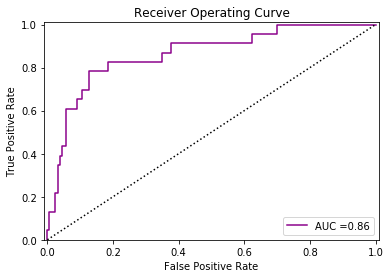

In [99]:
from sklearn.metrics import roc_curve, roc_auc_score

roc_auc=roc_auc_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred, drop_intermediate=False)

plt.title('Receiver Operating Curve')
plt.plot(fpr, tpr, 'darkmagenta', label = f"AUC ={round(roc_auc,2)}" )
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k:')
plt.xlim([-0.01, 1.01])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

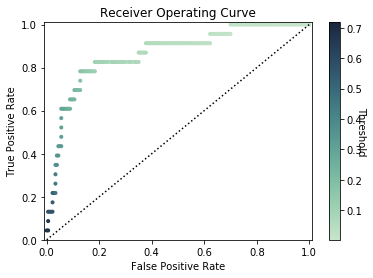

In [171]:
import seaborn as sns

curve = pd.DataFrame({"fpr":fpr[1:], "tpr":tpr[1:], "thresholds":thresholds[1:]})

cmap = sns.cubehelix_palette(as_cmap=True, rot=-.4)
points = plt.scatter(fpr[1:], tpr[1:], c=thresholds[1:], marker=".", cmap=cmap)

cbar = plt.colorbar(points)
cbar.ax.set_ylabel('Threshold', rotation = 270)

plt.title('Receiver Operating Curve')
plt.plot([0, 1], [0, 1],'k:')
plt.xlim([-0.01, 1.01])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Describe the meaning of AUC in this context.




>The probability the model can correctly differentiate between a randomly selected parole violator and a randomly selected parole non-violator.

#### Identifying Bias in Observational Data

Our goal has been to predict the outcome of a parole decision, and we used a publicly available dataset of parole releases for predictions. In this final problem, we'll evaluate a potential source of bias associated with our analysis. It is always important to evaluate a dataset for possible sources of bias.

The dataset contains all individuals released from parole in 2004, either due to completing their parole term or violating the terms of their parole. However, it does not contain parolees who neither violated their parole nor completed their term in 2004, causing non-violators to be underrepresented. This is called "selection bias" or "selecting on the dependent variable," because only a subset of all relevant parolees were included in our analysis, based on our dependent variable in this analysis (parole violation). How could we improve our dataset to best address selection bias?

> We should use a dataset tracking a group of parolees from the start of their parole until either they violated parole or they completed their term.

### Reference

1. [Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani, An Introduction to Statistical Learning with Applications in R, 2013.](http://faculty.marshall.usc.edu/gareth-james/ISL/)